# Daily maxima

In [1]:
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import box

YEARS = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

def label_gridpoints(df):
    grid_ids = df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).agg(sum).reset_index()
    grid_ids = {(row.latitude, row.longitude): row.Index for row in grid_ids.itertuples()}
    df['grid'] = df.apply(lambda row: grid_ids[(row.latitude, row.longitude)], axis=1)
    return df


def pivot_observations(df, value):
    df = df[['time', 'cyclone_flag', 'grid', value]]
    df = df.dropna()
    df = df.pivot(index=['time', 'cyclone_flag'], columns=['grid'], values=[value])
    df.columns = df.columns.get_level_values(1)
    return df


data = "wind_data"
indir = f"/Users/alison/Documents/DPhil/data/era5/{data}"
outdir = f"/Users/alison/Documents/DPhil/multivariate/{data}"

# Create file for all years

In [2]:
# setup
# load ibtracs within mask
if False:
    YEAR = YEARS[0]
    ds = xr.open_dataset(os.path.join(indir, f'bangladesh_{YEAR}.nc'))
    df = ds.to_dataframe().reset_index()
    df = df.fillna(0.)
    xmin, xmax = df['longitude'].min(), df['longitude'].max()
    ymin, ymax = df['latitude'].min(), df['latitude'].max()
    print(f"Longitude bounds: [{xmin}, {xmax}]")
    print(f"Latitude bounds: [{ymin}, {ymax}]")
    mask = box(xmin, ymin, xmax, ymax)
    ibtracs = gpd.read_file('/Users/alison/Documents/DPhil/data/ibtracs/ibtracs_since1980_points.gpkg', mask=mask)

    # get dailymax values
    df_dailymax = df.groupby(['latitude', 'longitude', pd.Grouper(key='time', freq='D')]).agg(max).reset_index()
    df_dailymax = label_gridpoints(df_dailymax)

    # save coordinates
    gdf = gpd.GeoDataFrame(df_dailymax, geometry=gpd.points_from_xy(df_dailymax.longitude, df_dailymax.latitude))
    gdf_coords = gdf[['grid', 'longitude', 'latitude', 'geometry']].drop_duplicates()
    gdf_coords = gdf_coords.reset_index(drop=True).set_crs(4326)
    gdf_coords.to_file(os.path.join(outdir, "dailymax_coords.gpkg"), driver='GPKG')
    coords_dict = {(x.latitude, x.longitude): x.grid for x in gdf_coords.itertuples()}

In [3]:
# cycle through all years
if False:
    for YEAR in YEARS:
        print(YEAR)
        if os.path.exists(os.path.join(indir, f'bangladesh_{YEAR}.nc')):
            if not os.path.exists(os.path.join(outdir, f"total_dailymax_{YEAR}.csv")):
                ds = xr.open_dataset(os.path.join(indir, f'bangladesh_{YEAR}.nc'))
                df = ds.to_dataframe().reset_index()
                df = df.fillna(0.)

                df['windspeed'] = np.sqrt(df['u10']**2 + df['v10']**2)
                # df['direction'] = np.arctan(df['u10'] / df['v10']) * (180 / np.pi)  # north is 0 degrees

                df_dailymax = df.groupby(['latitude', 'longitude', pd.Grouper(key='time', freq='D')]).agg(max).reset_index()
                df_dailymax['grid'] = df_dailymax.apply(lambda row: coords_dict[row.latitude, row.longitude], axis=1)

                # load IBTrACs to add cyclone flag
                ibtracs_year = ibtracs[ibtracs['SEASON'] == YEAR].copy()
                storm_times = [*pd.to_datetime(ibtracs_year['ISO_TIME'])]
                df_dailymax['cyclone_flag'] = df_dailymax['time'].isin(storm_times)

                df_u10 = pivot_observations(df_dailymax, 'u10')
                df_v10 = pivot_observations(df_dailymax, 'v10')
                df_speed = pivot_observations(df_dailymax, 'windspeed')
                df_u10.to_csv(os.path.join(outdir, f"u10_dailymax_{YEAR}.csv"))
                df_v10.to_csv(os.path.join(outdir, f"v10_dailymax_{YEAR}.csv")) 
                df_speed.to_csv(os.path.join(outdir, f"total_dailymax_{YEAR}.csv"))

            else:
                print(f"{YEAR} already processed.")
        else:
            print(f"No file for {YEAR}")
    !say done

In [4]:
if False:
    dfs_u10 = []
    dfs_v10 = []
    dfs_total = []
    for YEAR in YEARS:
        if os.path.exists(os.path.join(outdir, f"u10_dailymax_{YEAR}.csv")):
            df_u10 = pd.read_csv(os.path.join(outdir, f"u10_dailymax_{YEAR}.csv"))
            df_v10 = pd.read_csv(os.path.join(outdir, f"v10_dailymax_{YEAR}.csv"))
            df_total = pd.read_csv(os.path.join(outdir, f"total_dailymax_{YEAR}.csv"))
            dfs_u10.append(df_u10)
            dfs_v10.append(df_v10)
            dfs_total.append(df_total)

    df_u10 = pd.concat(dfs_u10).reset_index(drop=True)
    df_v10 = pd.concat(dfs_v10).reset_index(drop=True)
    df_total = pd.concat(dfs_total).reset_index(drop=True)

    df_u10.to_csv(os.path.join(outdir, f"u10_dailymax.csv"))
    df_v10.to_csv(os.path.join(outdir, f"v10_dailymax.csv"))
    df_total.to_csv(os.path.join(outdir, f"total_dailymax.csv"))
    !say done
    df_total.head()

## EDA

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_total = pd.read_csv(os.path.join(outdir, f"total_dailymax.csv"), index_col=[0])
df_total['time'] = pd.to_datetime(df_total['time'])
df_ts = df_total.set_index('time')

### Autocorrelations

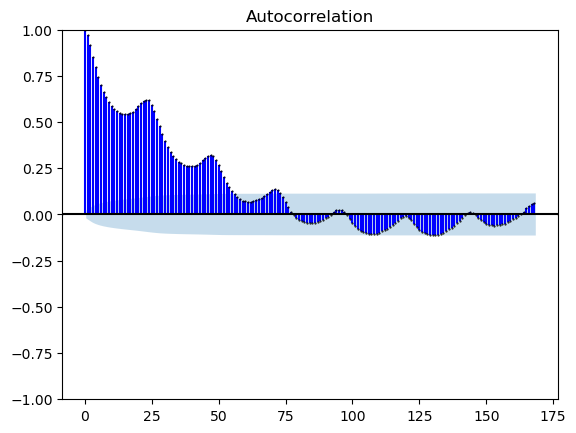

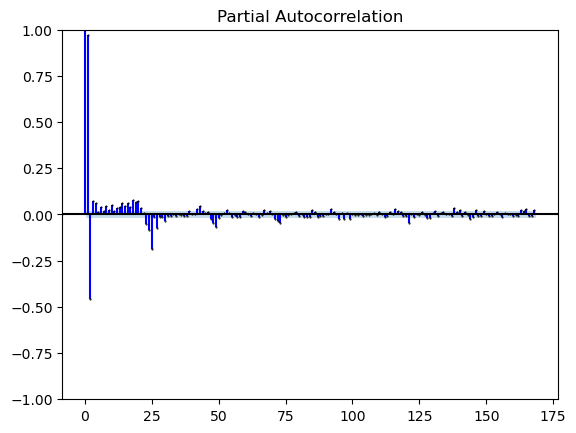

In [15]:
# have a look at the hourly data as a benchmark
YEAR = YEARS[0]
ds = xr.open_dataset(os.path.join(indir, f'bangladesh_{YEAR}.nc'))
df_hourly = ds.to_dataframe().reset_index()
df_hourly = df_hourly.fillna(0.)
df_hourly = df_hourly[(df_hourly['longitude'] == 80) & (df_hourly['latitude'] == 25)]
df_hourly['time'] = pd.to_datetime(df_hourly['time'])
df_hourly = df_hourly.set_index('time')[['u10', 'v10']]

plot_acf(df_hourly['u10'], lags=(24 * 7), marker='.', color='k', markersize=1, vlines_kwargs={'color': 'blue'});
plot_pacf(df_hourly['u10'], lags=(24 * 7), marker='.', color='k', markersize=1, vlines_kwargs={'color': 'blue'});

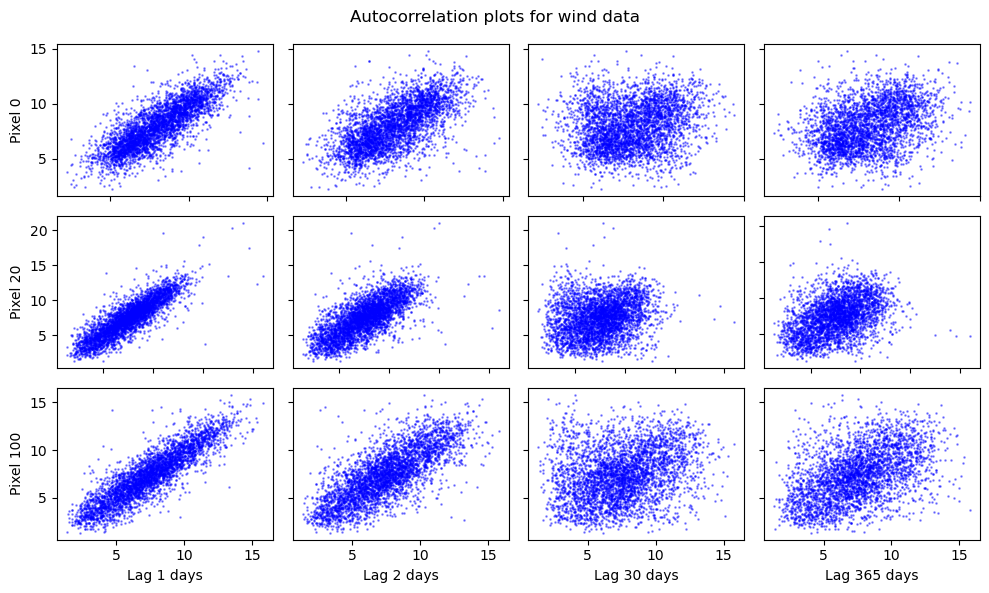

In [16]:
pixels = ['0', '20', '100']
lags = [1, 2, 30, 365]

fig, axs = plt.subplots(len(pixels), len(lags), figsize=(10, 6), layout='tight')
for i, pixel in enumerate(pixels):
    for j, lag in enumerate(lags):
        pd.plotting.lag_plot(df_ts[pixel], lag=lag, ax=axs[i, j], c='blue', s=.8, alpha=.4, edgecolor='blue')
        axs[i, j].set_ylabel("Pixel {}".format(pixel))
        axs[i, j].set_xlabel("Lag {} days".format(lag))
        axs[i, j].label_outer()
        
plt.suptitle('Autocorrelation plots for {}'.format(data.replace('_', ' ')));

Now appears stationary but with cut-off at lag 1.


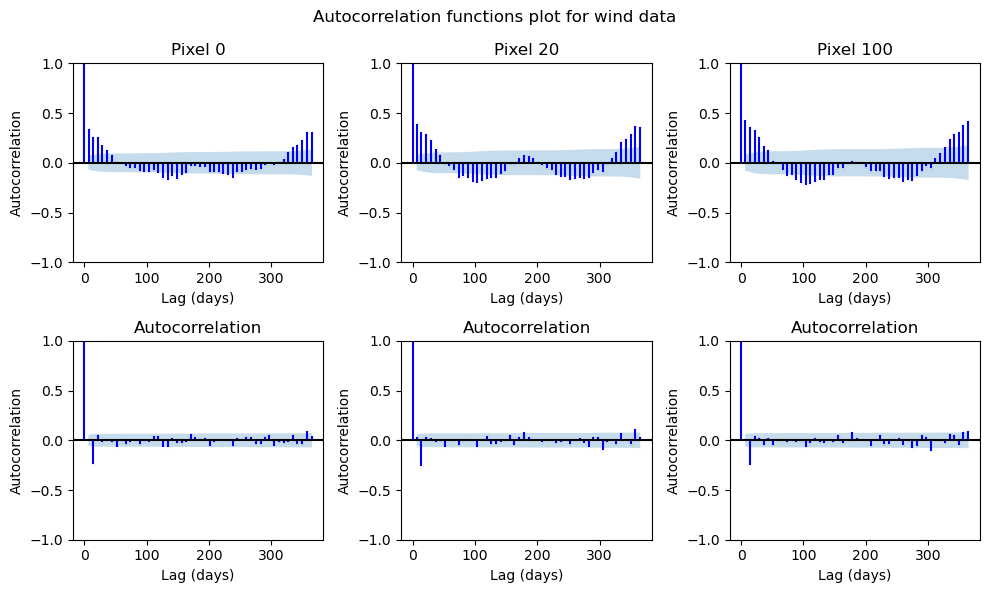

In [24]:
fig, axs = plt.subplots(2, len(pixels), figsize=(10, 6), layout='tight')
lags = np.linspace(0, 365, 50)

for ax, pixel in zip(axs[0, :], pixels):
    plot_acf(df_ts[pixel], lags=lags, marker='.', color='k', markersize=.1, ax=ax, vlines_kwargs={'color': 'blue'});
    ax.set_title('Pixel {}'.format(pixel))

for ax, pixel in zip(axs[1, :], pixels):
    plot_acf(df_ts[pixel].diff(12)[12:], lags=lags, marker='.', color='k', markersize=.1, ax=ax, vlines_kwargs={'color': 'blue'});
    

for ax in axs.ravel():
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')
    
fig.suptitle('Autocorrelation functions plot for {}'.format(data.replace('_', ' ')));

print('Now appears stationary but with cut-off at lag 1.')

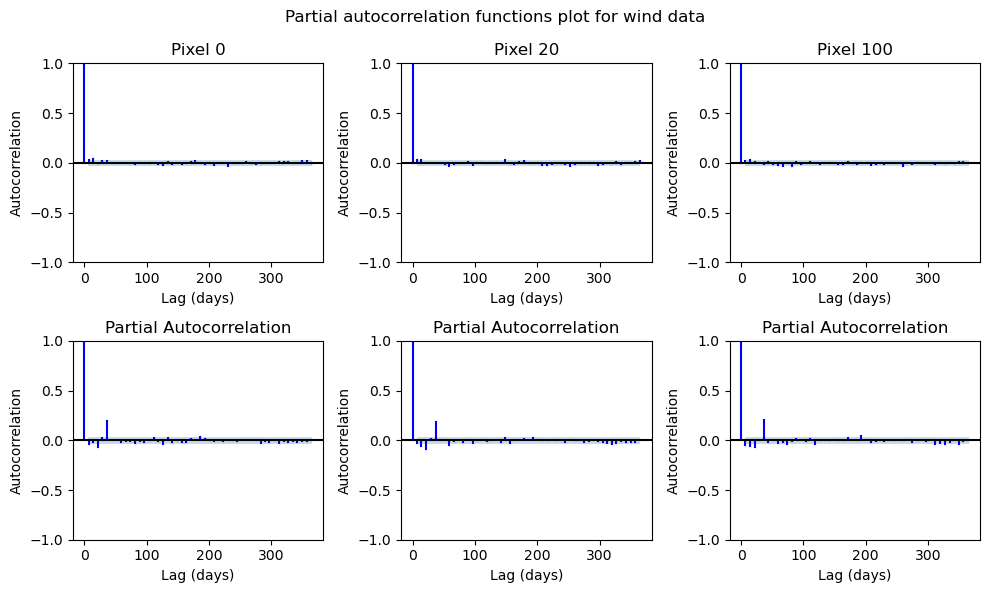

In [25]:
fig, axs = plt.subplots(2, len(pixels), figsize=(10, 6), layout='tight')
lags = np.linspace(0, 365, 50)

for ax, pixel in zip(axs[0, :], pixels):
    plot_pacf(df_ts[pixel], lags=lags, marker='.', color='k', markersize=.1, ax=ax, vlines_kwargs={'color': 'blue'});
    ax.set_title('Pixel {}'.format(pixel))

for ax, pixel in zip(axs[1, :], pixels):
    plot_pacf(df_ts[pixel].diff(12)[12:], lags=lags, marker='.', color='k', markersize=.1, ax=ax, vlines_kwargs={'color': 'blue'});
    

for ax in axs.ravel():
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')
    
fig.suptitle('Partial autocorrelation functions plot for {}'.format(data.replace('_', ' ')));

In [50]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA(endog, exog=None, order=(0, 0, 0), seasonal_order=(0, 1, 0, 0), freq=365)
model = ARIMA(df_ts[pixels[0]].values, order=(1, 0, 0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3652
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -5906.751
Date:                Mon, 25 Sep 2023   AIC                          11819.502
Time:                        13:24:30   BIC                          11838.112
Sample:                             0   HQIC                         11826.129
                               - 3652                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0156      0.104     76.941      0.000       7.811       8.220
ar.L1          0.8055      0.010     82.440      0.000       0.786       0.825
sigma2         1.4868      0.026     57.283      0.0

In [57]:
help(model.predict)

Help on method predict in module statsmodels.tsa.statespace.mlemodel:

predict(start=None, end=None, dynamic=False, information_set='predicted', signal_only=False, **kwargs) method of statsmodels.tsa.arima.model.ARIMAResultsWrapper instance
    predict(self, start=None, end=None, dynamic=False, information_set='predicted', signal_only=False, **kwargs)
    
    In-sample prediction and out-of-sample forecasting
    
    Parameters
    ----------
    start : {int, str,datetime}, optional
        Zero-indexed observation number at which to start forecasting,
        i.e., the first forecast is start. Can also be a date string to
        parse or a datetime type. Default is the zeroth observation.
    end : {int, str,datetime}, optional
        Zero-indexed observation number at which to end forecasting, i.e.,
        the last forecast is end. Can also be a date string to
        parse or a datetime type. However, if the dates index does not
        have a fixed frequency, end must be an i

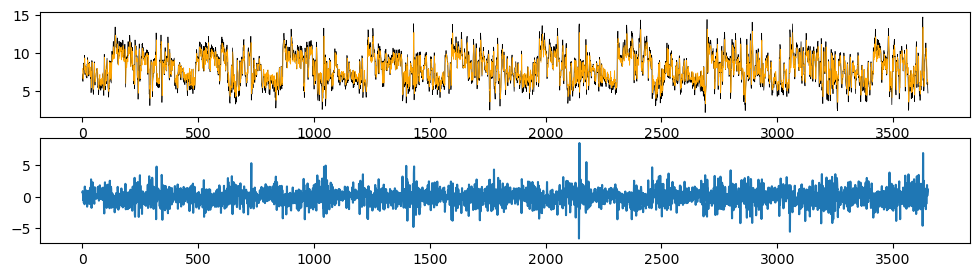

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(12, 3))

ax[0].plot(df_ts[pixels[0]].values, linewidth=.5, color='k')
ax[0].plot(model.predict(), linewidth=.5, color='orange')


ax[1].plot(model.predict() - df_ts[pixels[0]].values)

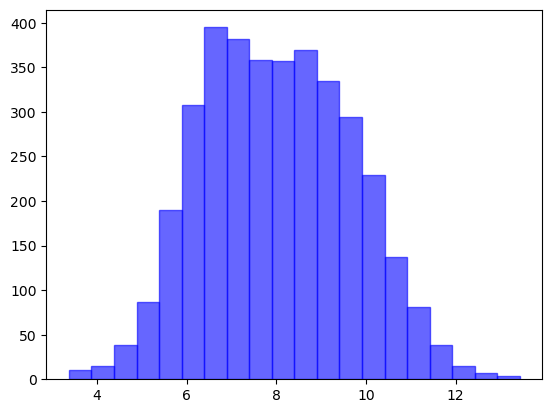

In [71]:
plt.hist(model.predict(), bins=20, color='blue', edgecolor='blue', alpha=.6);

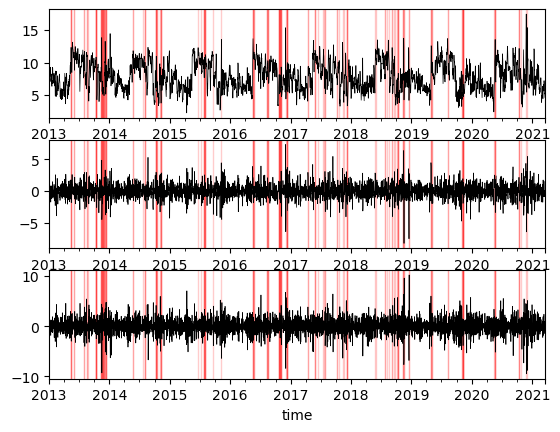

In [9]:
line_kwargs = {'color': 'k', 'linewidth': .5}
node = '3'
n = 3000

fig, ax = plt.subplots(3, 1)

df_ts[node].head(n).plot(ax=ax[0], **line_kwargs);
df_ts[node].diff().head(n).plot(ax=ax[1], **line_kwargs);
df_ts[node].diff().diff().head(n).plot(ax=ax[2], **line_kwargs);

for time in df_ts.query('cyclone_flag').index.values:
    ax[0].axvline(x=time, color='red', lw=1, alpha=.2, zorder=0)
    ax[1].axvline(x=time, color='red', lw=1, alpha=.2, zorder=0)
    ax[2].axvline(x=time, color='red', lw=1, alpha=.2, zorder=0)

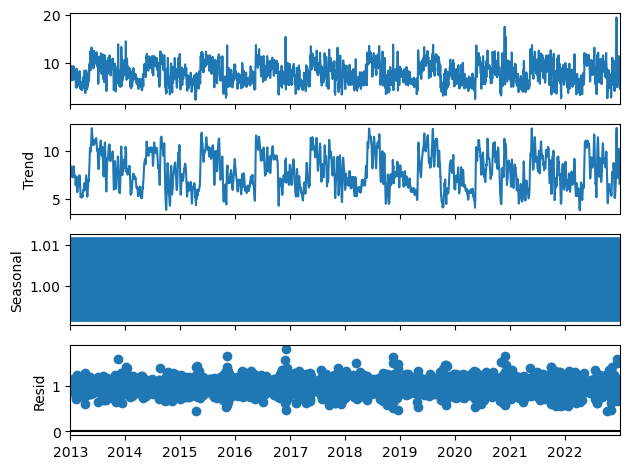

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# use a multiplicative model since figures above look multiplicative
decompose_result_mult = seasonal_decompose(df_ts[[node]], model="multiplicative") # .diff()[1:]

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();
 
# from this we can see that seasonal variation is of the order O(1e-2) and trend of the order O(1)

    # what sort of distribution does it have?
    import numpy as np
    import matplotlib.pyplot as plt


    hist_kwargs = {'color': 'blue', 'alpha': .6, 'edgecolor': 'blue'}

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))

    axs[0].hist(df_u10.iloc[:, 2:].values.ravel(), bins=100, **hist_kwargs);
    axs[1].hist(df_v10.iloc[:, 2:].values.ravel(), bins=100, **hist_kwargs);
    axs[2].hist(df_total.iloc[:, 2:].values.ravel(), bins=100, **hist_kwargs);


    # it really isn't very normal, it's quite peaked

# Try AR model

In [12]:
df_ts

,cyclone_flag,0,1,2,3,4,5,6,7,8,...,3711,3712,3713,3714,3715,3716,3717,3718,3719,3720
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,False,7.309017,7.301830,7.703349,7.448474,7.508606,7.679445,7.815555,7.869347,8.082762,...,1.722115,1.798949,1.734434,1.429570,1.553526,1.560519,1.698968,1.905427,1.649403,1.523781
2013-01-02,False,6.547694,6.319230,6.431759,6.155786,5.931107,6.151896,6.281800,6.445232,6.597524,...,1.821232,1.724601,1.774474,1.463000,1.579833,1.875185,2.145199,2.104595,1.695381,1.383900
2013-01-03,False,6.323210,6.562120,7.059585,7.083282,7.184775,7.334937,7.385500,7.444225,7.464698,...,1.844962,1.885171,1.949377,1.716505,1.803783,2.009658,2.260022,2.194314,2.181522,2.090440
2013-01-04,False,7.182588,7.021085,7.222329,6.905667,6.931654,7.067035,6.913355,6.846048,6.860641,...,1.911868,1.797997,1.761831,1.287654,1.541061,1.850651,1.999422,1.497343,1.528383,1.635556
2013-01-05,False,7.235443,7.408695,7.827010,7.876974,7.989972,8.371500,8.472582,8.614433,8.754127,...,1.889898,1.633483,1.543137,1.248455,1.604121,1.797965,1.975705,1.884879,1.573759,1.466828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,False,5.942558,5.824892,5.892916,5.854236,6.050915,6.303083,6.329775,6.253533,6.183716,...,1.961302,2.044718,2.605781,2.218680,2.399459,2.481829,3.145555,3.160071,2.200375,2.052961
2022-12-28,False,6.202149,5.995149,6.305494,6.154235,6.269315,6.490087,6.461582,6.440977,6.392478,...,1.862135,1.787427,1.848222,1.718028,1.997267,2.297364,2.619732,2.233905,1.595360,1.955162
2022-12-29,False,6.059605,5.710501,5.989375,5.745112,5.722390,5.952470,5.960591,6.022449,6.121874,...,1.832704,1.695445,1.701853,1.302793,1.571553,1.850628,2.213749,2.096406,1.568917,2.184487


# Visualise

In [101]:
import os
import matplotlib.pyplot as plt
from shapely.geometry import box

cyclone = True

df_total = pd.read_csv(os.path.join(outdir, f"total_dailymax.csv"), index_col=[0])

df_total['cyclone_flag'].unique()
df_total = df_total[df_total['cyclone_flag']==cyclone]


total_df = df_total.iloc[:, 2:].transpose()
total_df = total_df.reset_index(names='grid')

lon_dict_r = {grid: coords[1] for coords, grid in coords_dict.items()}
lat_dict_r = {grid: coords[0] for coords, grid in coords_dict.items()}

total_df['lon'] = total_df['grid'].astype(int).map(lon_dict_r)
total_df['lat'] = total_df['grid'].astype(int).map(lat_dict_r)
total_gdf = gpd.GeoDataFrame(total_df, geometry=gpd.points_from_xy(total_df['lon'], total_df['lat']))

In [107]:
# also visualise nearby coastline
coastline = gpd.read_parquet("/Users/alison/Documents/DPhil/data/openstreetmap/coastlines-osm.parquet")
coastline = coastline.to_crs(4326)
mask = box(*coords.total_bounds)
coastline = coastline.clip(mask)

/Users/alison/mambaforge/envs/general/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [109]:
total_gdf.head()

,grid,132,133,134,135,149,150,211,212,231,...,3415,3416,3417,3517,3518,3583,3629,lon,lat,geometry
0,0,10.778542,11.540197,10.656366,10.198107,10.735450,12.007983,11.395076,10.832816,10.956996,...,10.730945,9.678687,9.372623,8.547558,8.537481,6.268406,14.742559,80.00,10.0,POINT (80.00000 10.00000)
1,1,10.750957,11.916637,10.151908,9.419195,10.472209,11.495604,10.972432,10.516459,10.449261,...,10.983782,9.317380,9.639311,8.235524,7.940234,6.715700,15.939449,80.25,10.0,POINT (80.25000 10.00000)
2,2,11.158269,12.350474,10.391113,9.710195,11.271307,11.798478,10.667235,10.423701,11.013325,...,11.753256,9.692873,10.306047,8.340551,8.128691,7.429870,17.572470,80.50,10.0,POINT (80.50000 10.00000)
3,3,11.157815,12.335620,10.526122,9.960874,11.404932,11.473534,10.529562,10.194093,11.157785,...,11.986095,9.693366,10.667381,8.261888,8.072224,7.401563,18.527424,80.75,10.0,POINT (80.75000 10.00000)
4,4,11.670561,12.532183,10.663652,10.238944,11.401313,11.851450,11.263337,10.650361,11.353113,...,12.263095,10.082090,11.077001,9.073919,8.206558,7.467026,19.579403,81.00,10.0,POINT (81.00000 10.00000)


Text(0.5, 1.0, 'Total 10 m wind (Bangladesh)')

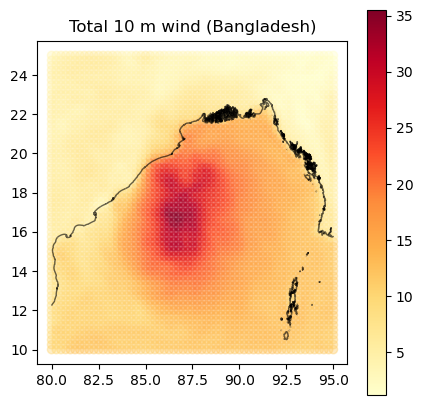

In [117]:
# plot most extremely large conditions
i = total_gdf.iloc[:, 2:-4].max(axis=0).idxmax()
# print(f"{i}: {total_gdf.iloc[:, :-1].max(axis=0).max():.2f} mps")


fig, ax = plt.subplots(figsize=(5, 5))

total_gdf.plot(i, cmap='YlOrRd', alpha=.4, ax=ax, legend=True)
coastline.plot(color='k', linewidth=1, alpha=.6, ax=ax)
ax.set_title('Total 10 m wind (Bangladesh)')

# fig.savefig(os.path.join("/Users/alison/Documents/DPhil/multivariate/evtGAN_code&data/figures", 'max_real_bgd.png'))